In [1]:
#!/usr/bin/python

import vtk
import numpy as np
import sys
import matplotlib.pyplot as plt 

from vtk import *
from vtk.util import numpy_support
from vtk.util.numpy_support import vtk_to_numpy
from vtk.util.vtkConstants import *

%matplotlib inline
#####

def numpy2VTK(img,spacing=[1.0,1.0,1.0]):
    # evolved from code from Stou S.,
    # on http://www.siafoo.net/snippet/314
    importer = vtk.vtkImageImport()
    
    img_data = img.astype('uint8')
    img_string = img_data.tostring() # type short
    dim = img.shape
    
    importer.CopyImportVoidPointer(img_string, len(img_string))
    importer.SetDataScalarType(VTK_UNSIGNED_CHAR)
    importer.SetNumberOfScalarComponents(1)
    
    extent = importer.GetDataExtent()
    importer.SetDataExtent(extent[0], extent[0] + dim[2] - 1,
                           extent[2], extent[2] + dim[1] - 1,
                           extent[4], extent[4] + dim[0] - 1)
#     importer.SetWholeExtent(extent[0], extent[0] + dim[2] - 1,
#                             extent[2], extent[2] + dim[1] - 1,
#                             extent[4], extent[4] + dim[0] - 1)

    importer.SetDataSpacing( spacing[0], spacing[1], spacing[2])
    importer.SetDataOrigin( 0,0,0 )

    return importer

def volumeRender(img, tf=[],spacing=[1.0,1.0,1.0]):
    importer = numpy2VTK(img,spacing)

    # Transfer Functions
    opacity_tf = vtk.vtkPiecewiseFunction()
    color_tf = vtk.vtkColorTransferFunction()

    if len(tf) == 0:
        tf.append([img.min(),0,0,0,0])
        tf.append([img.max(),1,1,1,1])

    for p in tf:
        color_tf.AddRGBPoint(p[0], p[1], p[2], p[3])
        opacity_tf.AddPoint(p[0], p[4])

    # working on the GPU
    volMapper = vtk.vtkGPUVolumeRayCastMapper()
    volMapper.SetInputConnection(importer.GetOutputPort())

    # # The property describes how the data will look
    # volProperty =  vtk.vtkVolumeProperty()
    # volProperty.SetColor(color_tf)
    # volProperty.SetScalarOpacity(opacity_tf)
    # volProperty.ShadeOn()
    # volProperty.SetInterpolationTypeToLinear()

#     # working on the CPU
#     #volMapper = vtk.vtkVolumeRayCastMapper()
#     volMapper = vtkFixedPointVolumeRayCastMapper()
#     #compositeFunction = vtk.vtkVolumeRayCastCompositeFunction()
#     #compositeFunction.SetCompositeMethodToInterpolateFirst()
#     #volMapper.SetVolumeRayCastFunction(compositeFunction)
#     volMapper.SetInputConnection(importer.GetOutputPort())

    # The property describes how the data will look
    volProperty =  vtk.vtkVolumeProperty()
    volProperty.SetColor(color_tf)
    volProperty.SetScalarOpacity(opacity_tf)
    #volProperty.ShadeOn()
    #volProperty.SetInterpolationTypeToLinear()
    
    # Do the lines below speed things up?
    pix_diag = 5.0
    volMapper.SetSampleDistance(pix_diag / 1.0)    
    volProperty.SetScalarOpacityUnitDistance(pix_diag) 
    

    vol = vtk.vtkVolume()
    vol.SetMapper(volMapper)
    vol.SetProperty(volProperty)
    
    return [vol]


def vtk_basic( actors ):
	"""
	Create a window, renderer, interactor, add the actors and start the thing
	
	Parameters
	----------
	actors :  list of vtkActors
	
	Returns
	-------
	nothing
	"""     
	
	# create a rendering window and renderer
	ren = vtk.vtkRenderer()
	renWin = vtk.vtkRenderWindow()
	renWin.AddRenderer(ren)
	renWin.SetSize(256,256)
	ren.SetBackground(0.0,0.0,0.0)
	
	ren.ResetCamera()    
	camera =vtkCamera ();
	#camera.SetPosition(128, 128, 128);
	#camera.SetFocalPoint(0, 0, -1);
	center = [128, 128, 128]
	camera.SetFocalPoint(center[0], center[1], center[2])
	camera.SetPosition(center[0], center[1]-512, center[2])
	camera.SetViewUp(0, 0, -1)
	
	ren.SetActiveCamera(camera)    
	# create a renderwindowinteractor
	iren = vtk.vtkRenderWindowInteractor()
	iren.SetRenderWindow(renWin)

	for a in actors:
		# assign actor to the renderer
		ren.AddActor(a )
	
	# render
	# renWin.Render()
	
   
	# # Set up the camera
#     camera  = ren.GetActiveCamera()
#     #center 	= volume.GetCenter()
#     camera.SetFocalPoint(128, 128, 128)
#     camera.SetPosition(128, 0, 128)
#     camera.SetViewUp(0, 0, -1)
	
	# enable user interface interactor
	# iren.Initialize()
	renWin.Render()
	# iren.Start()
	
	# Get the image
	vtk_win_im = vtk.vtkWindowToImageFilter()
	vtk_win_im.SetInput(renWin)
	vtk_win_im.Update()

	vtk_image = vtk_win_im.GetOutput()

	width, height, _ = vtk_image.GetDimensions()
	vtk_array = vtk_image.GetPointData().GetScalars()
	components = vtk_array.GetNumberOfComponents()

	img2d = vtk_to_numpy(vtk_array).reshape(height, width, components)
	
	# Close the render
	# render_window = iren.GetRenderWindow()
	# render_window.Finalize()
	# iren.GetRenderWindow().Finalize()
	# iren.TerminateApp()

	renWin.Finalize()
	
	# def close_window(iren):
	# 	render_window = iren.GetRenderWindow()
	# 	render_window.Finalize()
	# 	iren.TerminateApp()
	# 	#del render_window, iren
	# 	#import keyboard
	# 	#keyboard.write('E',delay=0)

	# close_window(iren)

	del renWin, iren
	

	return img2d

(256, 256, 3)


(-0.5, 255.5, 255.5, -0.5)

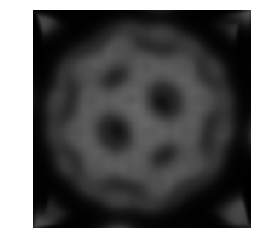

In [2]:
        

#####

# img = sitk.ReadImage( filename ) # SimpleITK object
# data = sitk.GetArrayFromImage( img ).astype('float') # numpy array
# data *= 255 / data.max()

# from scipy.stats.mstats import mquantiles
# q = mquantiles(data.flatten(),[0.7,0.98])
# q[0]=max(q[0],1)
# q[1] = max(q[1],1)
# tf=[[0,0,0,0,0],[q[0],0,0,0,0],[q[1],1,1,1,0.5],[data.max(),1,1,1,1]]

# actor_list = volumeRender(data, tf=tf, spacing=img.GetSpacing())

# vtk_basic(actor_list)

import skimage.io

fname ='data/image_3d/bucky_256.tif'
data  = skimage.io.imread(fname).astype(np.float32)

# from scipy.stats.mstats import mquantiles
# q = mquantiles(data.flatten(),[0.7,0.98])
# q[0]=max(q[0],1)
# q[1] = max(q[1],1)
# tf=[[0,0,0,0,0],[q[0],0,0,0,0],[q[1],1,1,1,0.5],[data.max(),1,1,1,1]]
# tf=[[0,0,0,0,0.5],[255, 1,1,1,.5]]
tf=[[0,0,0,0,0.0],[255, 1,1,1,1]]


actor_list = volumeRender(data, tf=tf)
img2d = vtk_basic(actor_list)
print(img2d.shape)
plt.imshow(img2d)
plt.axis('off')

In [3]:
pwd

u'/home/tmquan/DeepRender'

In [4]:
cd DeepRender

[Errno 2] No such file or directory: 'DeepRender'
/home/tmquan/DeepRender
